# Model without Keras

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils import to_categorical
fashion_mnist = keras.datasets.fashion_mnist
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

In [2]:
train_X, test_X = train_X.reshape(train_X.shape[0], 28, 28, 1), test_X.reshape(test_X.shape[0], 28, 28, 1)
train_y, test_y = to_categorical(train_y), to_categorical(test_y)
train_X = train_X/ 255
test_X = test_X/ 255

In [3]:
# MNIST data input (img shape: 28*28)
n_input = 28

# MNIST total classes (0-9 digits)
n_classes = 10

training_iters = 20
learning_rate = 0.01 
batch_size = 500

In [4]:
x = tf.compat.v1.placeholder("float", [None, n_input,n_input,1])
y = tf.compat.v1.placeholder("float", [None, n_classes])

In [5]:
def conv2d(x, W, b, strides, pad):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=pad)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool2d(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [6]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'], 1,'VALID')
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'],1, 'SAME')
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

   
    flatten = tf.reshape(conv2, [-1,3*6*6])

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    
    fc1 = tf.add(tf.matmul(flatten, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Fully connected layer
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return out

In [7]:
weights = {
    'wc1': tf.compat.v1.get_variable('W0', shape=(5,5,1,3), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.compat.v1.get_variable('W1', shape=(3,3,3,3), initializer=tf.contrib.layers.xavier_initializer()), 

    'wd1': tf.compat.v1.get_variable('W3', shape=(108,100), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd2': tf.compat.v1.get_variable('W4', shape=(100,50), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.compat.v1.get_variable('W5', shape=(50,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.compat.v1.get_variable('B0', shape=(3), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.compat.v1.get_variable('B1', shape=(3), initializer=tf.contrib.layers.xavier_initializer()),

    'bd1': tf.compat.v1.get_variable('B3', shape=(100), initializer=tf.contrib.layers.xavier_initializer()),
    'bd2': tf.compat.v1.get_variable('B4', shape=(50), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.compat.v1.get_variable('B5', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [8]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Initializing the variables
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.compat.v1.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))

        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    saver = tf.train.Saver()
    saver.save(sess, 'my-test-model')
    summary_writer.close()

Iter 0, Loss= 0.434108, Training Accuracy= 0.82400
Testing Accuracy: 0.80250
Iter 1, Loss= 0.360577, Training Accuracy= 0.85600
Testing Accuracy: 0.83570
Iter 2, Loss= 0.342572, Training Accuracy= 0.87000
Testing Accuracy: 0.84290
Iter 3, Loss= 0.334483, Training Accuracy= 0.87200
Testing Accuracy: 0.84660
Iter 4, Loss= 0.324773, Training Accuracy= 0.87000
Testing Accuracy: 0.84870
Iter 5, Loss= 0.317488, Training Accuracy= 0.87800
Testing Accuracy: 0.85530
Iter 6, Loss= 0.315873, Training Accuracy= 0.88000
Testing Accuracy: 0.85560
Iter 7, Loss= 0.308116, Training Accuracy= 0.88200
Testing Accuracy: 0.85950
Iter 8, Loss= 0.323304, Training Accuracy= 0.86200
Testing Accuracy: 0.85670
Iter 9, Loss= 0.308618, Training Accuracy= 0.87000
Testing Accuracy: 0.86240
Iter 10, Loss= 0.307483, Training Accuracy= 0.87800
Testing Accuracy: 0.86190
Iter 11, Loss= 0.312047, Training Accuracy= 0.87800
Testing Accuracy: 0.86180
Iter 12, Loss= 0.295115, Training Accuracy= 0.88200
Testing Accuracy: 0.86

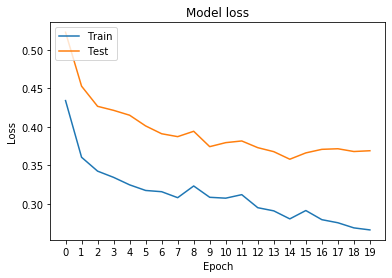

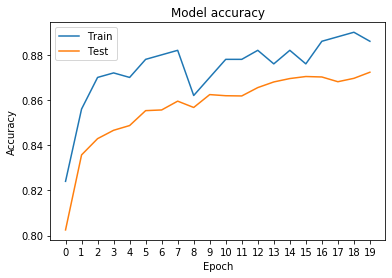

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xticks(range(0,20))
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xticks(range(0,20))
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model with Keras

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.optimizers import Adadelta
#load data
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images, test_images = train_images.reshape(train_images.shape[0], 28, 28, 1), test_images.reshape(test_images.shape[0], 28, 28, 1)
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)
#create model
def create_model():
    model = Sequential()
    #add model layers
    model.add(Conv2D(3, kernel_size=5, strides = 1, activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(strides=(2, 2)))
    model.add(Conv2D(3, kernel_size=3, strides = 1, padding='same', activation='relu'))
    model.add(MaxPooling2D(strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adadelta(),loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model()
model.summary()


##saving checkpoints
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#
## Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_images, train_labels,batch_size = 100,epochs=20, validation_data=(test_images, test_labels),
          callbacks=[cp_callback])
score = model.evaluate(test_images,  test_labels, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]) 


#Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

# Loads the weights
model.load_weights(checkpoint_path)
print(checkpoint_path)
# Re-evaluate the model
loss,acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 3)         78        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 3)         84        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 3)           0         
_________________________________________________________________
flatten (Flatten)            (None, 108)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10900     
____

60000/60000 [==============================] - 31s 510us/sample - loss: 0.3524 - acc: 0.8684 - val_loss: 0.4056 - val_acc: 0.8500
Epoch 11/20
59800/60000 [============================>.] - ETA: 0s - loss: 0.3457 - acc: 0.8711
Epoch 00011: saving model to training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
60000/60000 [==============================] - 27s 442us/sample - loss: 0.3455 - acc: 0.8712 - val_loss: 0.4121 - val_acc: 0.8539
Epoch 12/20
59800/60000 [============================>.] - ETA: 0s - loss: 0.3382 - acc: 0.8732
Epoch 00012: saving model to training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
60000/60000 [==============================] - 27s 455us/sample - loss: 0.3380 - acc: 0.8733 - val_loss: 0.4062 - val_acc: 0.8550
Epoch 13/20
59900/60000 [============================>.] - ETA: 0s - loss: 0.3306 - acc: 0.8763
Epoch 00013: saving model to training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
60000/6000

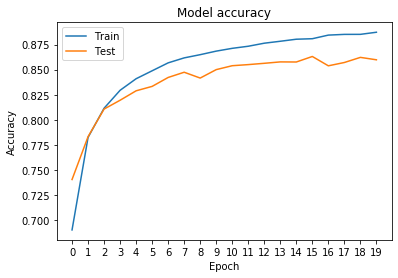

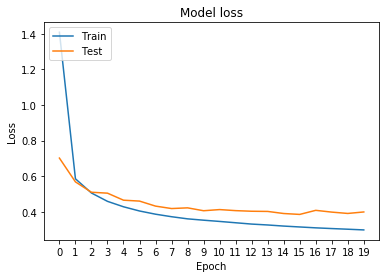

In [12]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xticks(range(0,20))
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xticks(range(0,20))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()